In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from catboost import CatBoostRegressor
from catboost import Pool

# pd.options.display.max_columns = None

In [31]:
request = requests.get("https://justjoin.it/api/offers")
data = request.json()
df = pd.DataFrame.from_dict(data)

In [32]:
contract_type_column = lambda data: data[0]["type"]
salary_from_type_column = lambda data: data[0]["salary"]["from"] if data[0]["salary"] is not None else data[0]["salary"]
salary_to_type_column = lambda data: data[0]["salary"]["to"] if data[0]["salary"] is not None else data[0]["salary"]
currency_type_column = lambda data: data[0]["salary"]["currency"] if data[0]["salary"] is not None else data[0]["salary"]


df["contract_type"] = df["employment_types"].apply(contract_type_column)
df["salary_from"] = df["employment_types"].apply(salary_from_type_column)
df["salary_to"] = df["employment_types"].apply(salary_to_type_column)
df["curr"] = df["employment_types"].apply(currency_type_column)

df.drop(columns=["employment_types"], inplace=True)

In [33]:
df["skill_types"] = df["skills"].apply(lambda x: [i["name"] for i in x])
df["skill_values"] = df["skills"].apply(lambda x: [i["level"] for i in x])

df.drop(columns=["skills"], inplace=True)

In [34]:
df.head(3)

,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,company_size,...,open_to_hire_ukrainians,id,company_logo_url,remote,contract_type,salary_from,salary_to,curr,skill_types,skill_values
0,"Sr Software Engineer, React Components",Centrum,Gdynia,PL,"Centrum, Gdynia",javascript,remote,PubNub,http://www.pubnub.com,100 - 150,...,False,pubnub-sr-software-engineer-react-components-g...,https://bucket.justjoin.it/offers/company_logo...,True,b2b,21000.0,27000.0,pln,"[Teamwork, TypeScript, JavaScript]","[3, 4, 4]"
1,Frontend Engineer,-,Wrocław,PL,"-, Wrocław",javascript,partly_remote,Grid Dynamics Poland,http://www.griddynamics.com,3000+,...,False,grid-dynamics-poland-frontend-engineer-wroclaw,https://bucket.justjoin.it/offers/company_logo...,False,b2b,18000.0,26000.0,pln,"[HTML / CSS, Angular 2+, JavaScript]","[5, 5, 5]"
2,"Sr Software Engineer, Full Stack",-,Dąbrowa Górnicza,PL,"-, Dąbrowa Górnicza",javascript,remote,PubNub,http://www.pubnub.com,100 - 150,...,False,pubnub-sr-software-engineer-full-stack-dabrowa...,https://bucket.justjoin.it/offers/company_logo...,True,b2b,21000.0,27000.0,pln,"[TypeScript, SQL, Cloud Platforms]","[4, 4, 4]"


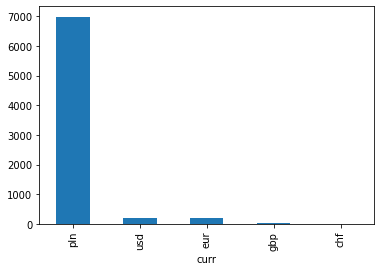

In [35]:
df.groupby("curr").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

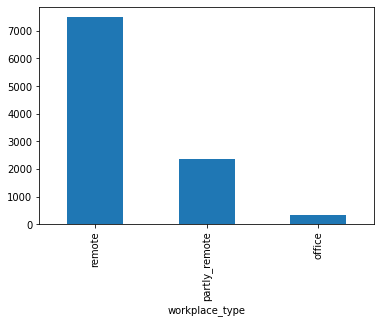

In [36]:
df.groupby("workplace_type").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

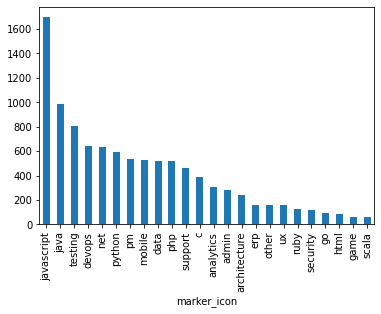

In [37]:
df.groupby("marker_icon").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()

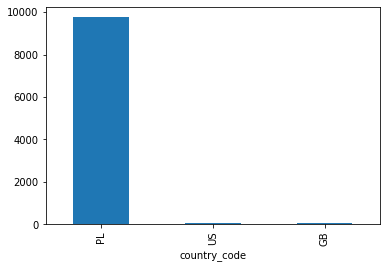

In [38]:
df.groupby("country_code").count()["id"].sort_values(ascending=False).head(3).plot(kind="bar")
plt.show()

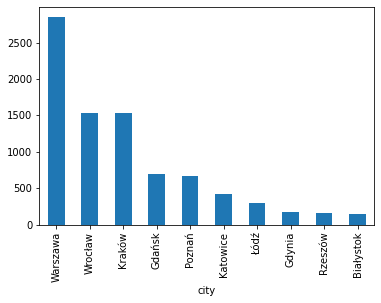

In [39]:
df.groupby("city").count()["id"].sort_values(ascending=False).head(10).plot(kind="bar")
plt.show()

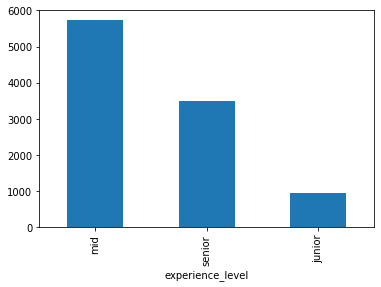

In [40]:
df.groupby("experience_level").count()["id"].sort_values(ascending=False).plot(kind="bar")
plt.show()


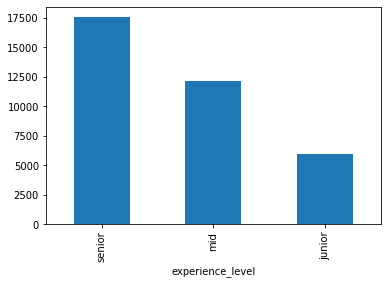

In [41]:
df.groupby("experience_level").mean()["salary_from"].sort_values(ascending=False).plot(kind="bar")
plt.show()

In [42]:
df.to_csv("salaries.csv", index=False)

In [43]:
df = df[df["country_code"] == "PL"]


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9761 entries, 0 to 10156
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    9761 non-null   object 
 1   street                   9759 non-null   object 
 2   city                     9761 non-null   object 
 3   country_code             9761 non-null   object 
 4   address_text             9761 non-null   object 
 5   marker_icon              9761 non-null   object 
 6   workplace_type           9761 non-null   object 
 7   company_name             9761 non-null   object 
 8   company_url              9761 non-null   object 
 9   company_size             9761 non-null   object 
 10  experience_level         9761 non-null   object 
 11  latitude                 9761 non-null   object 
 12  longitude                9761 non-null   object 
 13  published_at             9761 non-null   object 
 14  remote_interview       

In [45]:
df.drop(['title',
        #  'city',
         'street',
         'country_code',
         'address_text',
         'company_name',
         'company_url',
         'company_size',
         'latitude',
         'longitude',
         'published_at',
         'open_to_hire_ukrainians',
         'id',
         'company_logo_url',
         'skill_types',
         'skill_values'
         ], axis=1, inplace=True)

In [46]:
df = df.dropna()

In [47]:
df['remote_interview'] = df['remote_interview'].astype('int')
df['remote'] = df['remote'].astype('int')
df = df[df["curr"] == "pln"]
df.drop(["curr"], axis=1, inplace=True)

In [48]:
le = LabelEncoder()
le_columns = ["experience_level", "workplace_type", "contract_type"]
df[le_columns] = df[le_columns].apply(lambda x: le.fit_transform(x))

In [49]:
#create new column salary_mean and calculate mean salary from salary_from and salary_to
df["salary_mean"] = df.apply(lambda x: (x["salary_from"] + x["salary_to"]) / 2, axis=1)

In [50]:
df.drop(['salary_from',
         'salary_to'
         ], axis=1, inplace=True)

In [51]:
df.head()

,city,marker_icon,workplace_type,experience_level,remote_interview,remote,contract_type,salary_mean
0,Gdynia,javascript,2,2,1,1,0,24000.0
1,Wrocław,javascript,1,2,1,0,0,22000.0
2,Dąbrowa Górnicza,javascript,2,2,1,1,0,24000.0
3,Warszawa,pm,2,1,1,1,0,18000.0
4,Częstochowa,mobile,2,1,1,1,0,18000.0


In [52]:
df = pd.get_dummies(df, columns=["marker_icon", "city"])

features_object = df.select_dtypes(include="object").columns
df = pd.get_dummies(df, columns=features_object)

In [53]:
df.head()

,workplace_type,experience_level,remote_interview,remote,contract_type,salary_mean,marker_icon_admin,marker_icon_analytics,marker_icon_architecture,marker_icon_c,...,city_Wieliczka,city_Wrocław,city_Wysogotowo,city_Włocławek,city_Zabierzów,city_Zabrze,city_Zielona Gora,city_Zielona Góra,city_Łódź,city_Świdnica
0,2,2,1,1,0,24000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,1,0,0,22000.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,2,1,1,0,24000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,1,1,0,18000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,1,1,0,18000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X = df.drop(["salary_mean"], axis=1)
y = df["salary_mean"]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(X_test.shape)

(5169, 102)
(1724, 102)


In [56]:
train_dataset = Pool(X_train, y_train)
test_dataset = Pool(X_test, y_test)

catboost_model = CatBoostRegressor(iterations=1000,
                                    learning_rate=0.1,
                                    depth=6,
                                    loss_function='RMSE',
                                    eval_metric='RMSE',
                                    random_seed=42,
                                    silent=True)
 
catboost_model.fit(train_dataset, eval_set=test_dataset)

cv_model = cross_val_score(
    catboost_model, X_train, y_train, cv=10, scoring="neg_mean_absolute_error"
)

y_preds = catboost_model.predict(X_test)
cv_model_mean = np.mean(cv_model)

In [57]:
print("Cross val score:", cv_model_mean)
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_preds)))

Cross val score: -3162.187037332737
RMSE:  4143.32197853337


In [68]:
X_test_new = pd.DataFrame(columns=X_train.columns)
X_test_new.loc[0] = [0] * len(X_test_new.columns)

In [98]:
X_test_new.loc[0]["remote"] = 1
X_test_new.loc[0]["city_Kraków"] = 1
X_test_new.loc[0]["remote_interview"] = 1
X_test_new.loc[0]["marker_icon_python"] = 1
X_test_new.loc[0]["experience_level"] = 2

In [100]:
catboost_model.predict(X_test_new)

array([18836.88837816])